In [1]:
#this tutotial exclusively shows how to compute the PATHCV variables s and z based on DeepLNE X_hat
#the variables can be exported as PyTorch CVs to bias MD simulations

In [2]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from pathlib import Path
import plumed
import torch
torch.manual_seed(42)
from skmatter.feature_selection import FPS
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Subset
from torch.utils.data.dataset import random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.ticker as ticker
from scipy.interpolate import griddata

In [3]:
PLUMED_EXE="plumed"

subprocess.run(f"{PLUMED_EXE}", shell=True)

def clean(folder='./'):
    subprocess.run("rm COLVAR KERNELS bck.* out* histogram* *log potential-coeffs.out.data stats.out", cwd=folder, shell=True)

Nothing to do. Use 'plumed help' for help


In [4]:
def muller_brown_potential_three_states(x, y):
    """Muller-Brown analytical potential"""
    prefactor = 0.15
    A = (-280, -170, -170, 15)
    a = (-15, -1, -6.5, 0.7)
    b = (0, 0, 11, 0.6)
    c = (-10, -10, -6.5, 0.7)
    x0 = (1, 0.2, -0.5, -1)
    y0 = (0, 0.5, 1.5, 1)
    offset = -146.7

    v = -prefactor * offset
    for i in range(4):
        v += (
            prefactor
            * A[i]
            * np.exp(
                a[i] * (x - x0[i]) ** 2
                + b[i] * (x - x0[i]) * (y - y0[i])
                + c[i] * (y - y0[i]) ** 2
            )
        )
    return v
MULLER_BROWN_FORMULA='0.15*(146.7-280*exp(-15*(x-1)^2+0*(x-1)*(y-0)-10*(y-0)^2)-170*exp(-1*(x-0.2)^2+0*(x-0)*(y-0.5)-10*(y-0.5)^2)-170*exp(-6.5*(x+0.5)^2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)^2)+15*exp(0.7*(x+1)^2+0.6*(x+1)*(y-1)+0.7*(y-1)^2))'

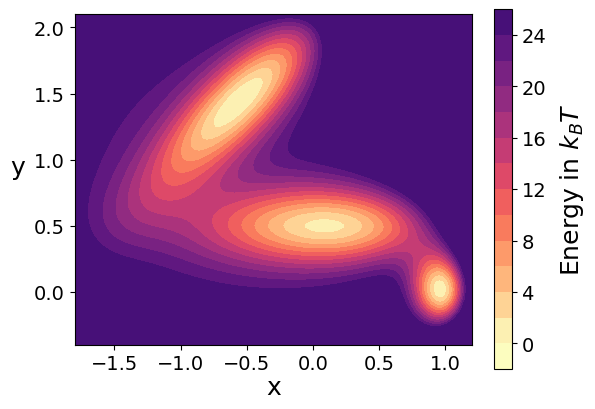

In [5]:
nx, ny = (100, 100)
xlims = (-1.8, 1.2)
ylims = (-0.4, 2.1)
x = np.linspace(xlims[0], xlims[1], nx)
y = np.linspace(ylims[0], ylims[1], ny)
xv, yv = np.meshgrid(x, y)

pot = muller_brown_potential_three_states(xv, yv)
max_pot = 26
pot[pot > max_pot] = max_pot  

magma = plt.colormaps["magma_r"] 
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256)))  

fig, ax = plt.subplots(dpi=100)
norm = mcolors.Normalize(vmin=np.min(pot), vmax=max_pot)  
pp = ax.contourf(xv, yv, pot, 16, cmap=new_magma, norm=norm)  
ax.set_aspect('equal')

cbar = plt.colorbar(pp, ax=ax)
cbar.ax.set_position([0.78, 0.1, 0.05, 0.75])  

cbar.set_label(r'Energy in $k_BT$', rotation=90, labelpad=8, fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18,labelpad=1)
plt.ylabel('y', rotation=0,fontsize=18,labelpad=12)
plt.show()


In [6]:
#ABMD

In [ ]:
!mkdir raw_data

In [12]:
kappas=[80] #[50,55,60,65,70]

for i in range(1,2):
    folder = 'raw_data/AB%s/'%str(i)

    Path(folder).mkdir(parents=True, exist_ok=True)

    with open(folder+"md_potential","w") as f:
        print("""#! FIELDS idx_dim1 idx_dim2 pot.coeffs index description
#! SET type LinearBasisSet
#! SET ndimensions  2
#! SET ncoeffs_total 9 
#! SET shape_dim1  3
#! SET shape_dim2  3
       0       0         0.0000000000000000e+00       0  1*1
#!-------------------
""",file=f)

    with open(folder+"md_input","w") as f:
        print("""
nstep                   10000000
tstep                   0.005
temperature             1.0
friction                10.0
random_seed             2  
plumed_input            plumed.dat
dimension               2
replicas                1
basis_functions_1       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
basis_functions_2       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
input_coeffs            md_potential
initial_position        0.9,0.0
output_potential        out_potential.data
output_potential_grid   100
output_histogram        histogram.data
""",file=f)

    with open(folder+"plumed.dat","w") as f:
        print(f"""# vim:ft=plumed
UNITS NATURAL
p: POSITION ATOM=1
ene: CUSTOM ARG=p.x,p.y PERIODIC=NO FUNC={MULLER_BROWN_FORMULA}
pot: BIASVALUE ARG=ene

abmd: ABMD ARG=p.y TO=1.5 KAPPA=%s

COMMITTOR ...
   ARG=p.x,p.y
   STRIDE=1
   BASIN_LL1=0,0.4
   BASIN_UL1=0.1,0.55
...

lwall: LOWER_WALLS ARG=p.x KAPPA=1000 AT=-1.3
uwall: UPPER_WALLS ARG=p.x KAPPA=1000 AT=+1.5

PRINT STRIDE=1 ARG=* FILE=COLVAR_ABMD_kappa%s
"""%(str(kappas[i-1]),str(kappas[i-1])),file=f)
    clean(folder)
    subprocess.run(f"{PLUMED_EXE} ves_md_linearexpansion < md_input &", cwd=folder, shell=True)

rm: cannot remove 'COLVAR': No such file or directory
rm: cannot remove 'KERNELS': No such file or directory
rm: cannot remove 'bck.*': No such file or directory
rm: cannot remove 'out*': No such file or directory
rm: cannot remove 'histogram*': No such file or directory
rm: cannot remove '*log': No such file or directory
rm: cannot remove 'potential-coeffs.out.data': No such file or directory
rm: cannot remove 'stats.out': No such file or directory


Replicas                              1
Cores per replica                     1
Number of steps                       10000000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -2
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
Basis Function 2                      BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


14032


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++
/tmp/ipykernel_217810/2483857684.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  transitions.append(torch.Tensor(transition))


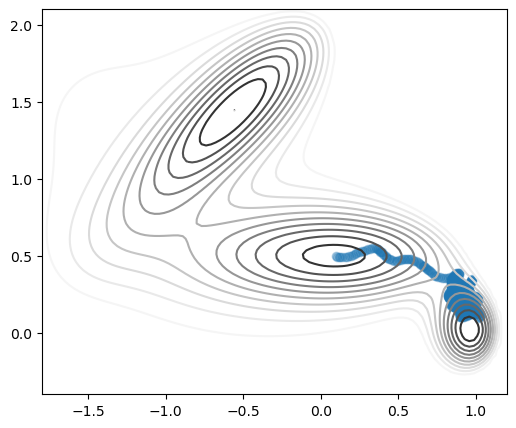

In [7]:
from skmatter.feature_selection import FPS

kappas=[80]

transitions=[]

selector = FPS(n_to_select=200,initialize=0)

for i in range(1,2):
    colvar=plumed.read_as_pandas("raw_data/AB%s/COLVAR_ABMD_kappa%s" %(i,kappas[i-1]))
    print(len(colvar))
    dynamics=np.array(colvar.iloc[::1,:3],dtype=float)[::-1]
    
    transition=[]
    for t in dynamics:

        transition.append(t[1:])

        if t[2] < 0.1:
            break
            
    transitions.append(torch.Tensor(transition))

_, ax = plt.subplots(1, figsize=(6,5), dpi=100)
ax.contour(xv,yv,pot,10,cmap='Greys_r')

for i in range(1):
    plt.scatter(transitions[i][:,0], transitions[i][:,1],alpha=0.3)
plt.show()   


In [9]:
kappas=[30]  

for i in range(6,7):
    folder = 'raw_data/AB%s/'%str(i)

    Path(folder).mkdir(parents=True, exist_ok=True)

    with open(folder+"md_potential","w") as f:
        print("""#! FIELDS idx_dim1 idx_dim2 pot.coeffs index description
#! SET type LinearBasisSet
#! SET ndimensions  2
#! SET ncoeffs_total 9 
#! SET shape_dim1  3
#! SET shape_dim2  3
       0       0         0.0000000000000000e+00       0  1*1
#!-------------------
""",file=f)

    with open(folder+"md_input","w") as f:
        print("""
nstep                   10000000
tstep                   0.005
temperature             1.0
friction                10.0
random_seed             1  
plumed_input            plumed.dat
dimension               2
replicas                1
basis_functions_1       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
basis_functions_2       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
input_coeffs            md_potential
initial_position        -0.6,1.2
output_potential        out_potential.data
output_potential_grid   100
output_histogram        histogram.data
""",file=f)

    with open(folder+"plumed.dat","w") as f:
        print(f"""# vim:ft=plumed
UNITS NATURAL
p: POSITION ATOM=1
ene: CUSTOM ARG=p.x,p.y PERIODIC=NO FUNC={MULLER_BROWN_FORMULA}
pot: BIASVALUE ARG=ene

abmd: ABMD ARG=p.y TO=0.4 KAPPA=%s

COMMITTOR ...
   ARG=p.x,p.y
   STRIDE=10
   BASIN_LL1=0,0.5
   BASIN_UL1=0.2,0.7
...

lwall: LOWER_WALLS ARG=p.x KAPPA=1000 AT=-1.3
uwall: UPPER_WALLS ARG=p.x KAPPA=1000 AT=+1.5

PRINT STRIDE=1 ARG=* FILE=COLVAR_ABMD_kappa%s
"""%(str(kappas[i-6]),str(kappas[i-6])),file=f)
    clean(folder)
    subprocess.run(f"{PLUMED_EXE} ves_md_linearexpansion < md_input &", cwd=folder, shell=True)

rm: cannot remove 'COLVAR': No such file or directory
rm: cannot remove 'KERNELS': No such file or directory
rm: cannot remove 'bck.*': No such file or directory
rm: cannot remove 'out*': No such file or directory
rm: cannot remove 'histogram*': No such file or directory
rm: cannot remove '*log': No such file or directory
rm: cannot remove 'potential-coeffs.out.data': No such file or directory
rm: cannot remove 'stats.out': No such file or directory


Replicas                              1
Cores per replica                     1
Number of steps                       10000000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -1
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
Basis Function 2                      BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed input


179541


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


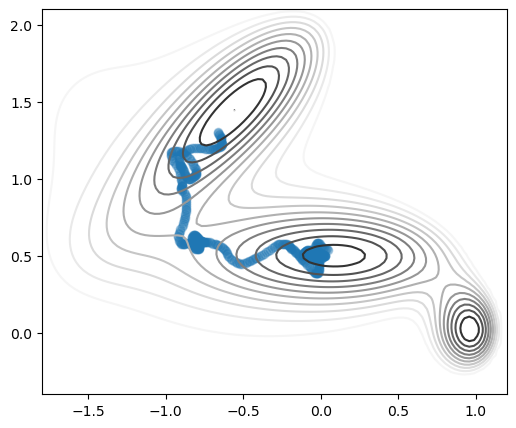

In [8]:
kappas=[30] 

transitions2=[]

selector = FPS(n_to_select=200,initialize=0)

for i in range(6,7):
    colvar=plumed.read_as_pandas("raw_data/AB%s/COLVAR_ABMD_kappa%s" %(i,kappas[i-6]))
    print(len(colvar))
    dynamics=np.array(colvar.iloc[::1,:3],dtype=float)[::-1]
    
    transition=[]
    for t in dynamics:

        transition.append(t[1:])

        if t[2] > 1.3:
            break
            
    transitions2.append(torch.Tensor(transition))

_, ax = plt.subplots(1, figsize=(6,5), dpi=100)
ax.contour(xv,yv,pot,10,cmap='Greys_r')

for i in range(1):
    plt.scatter(transitions2[i][:,0], transitions2[i][:,1],alpha=0.3)
plt.show()   


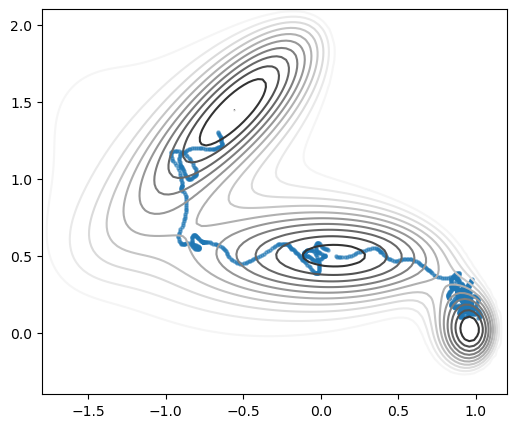

In [9]:
training_batches=[]
for i in range(1):
    training_batches.append(np.vstack((transitions[i],transitions2[i])))
    
training_datapoints=np.concatenate(training_batches)
                            
_, ax = plt.subplots(1, figsize=(6,5), dpi=100)
ax.contour(xv,yv,pot,10,cmap='Greys_r')

for i in range(1):
    plt.scatter(training_batches[i][:,0], training_batches[i][:,1],alpha=0.5,s=5)
plt.show()   

In [10]:
print(training_datapoints.shape)
training_batches = np.array_split(training_datapoints, 4)
training_batches=np.array(training_batches)
print(training_batches.shape)

(1103, 2)
(4,)


/tmp/ipykernel_217810/4100881711.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_batches=np.array(training_batches)


(200, 2)


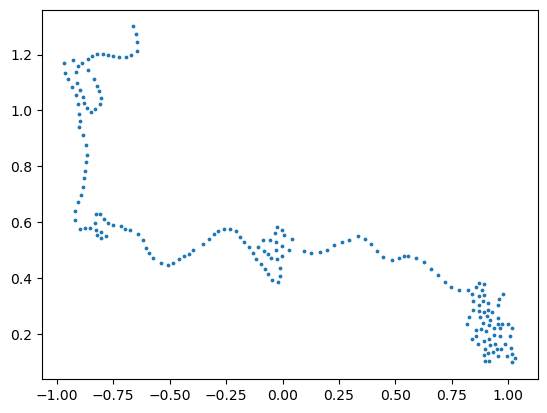

In [11]:
selector = FPS(n_to_select=200,initialize=0)

selector.fit(training_datapoints.T)
model_datapoints = selector.transform(training_datapoints.T).T

print(model_datapoints.shape)

plt.figure()
plt.scatter(model_datapoints[:,0],model_datapoints[:,1],s=3,alpha=1)
plt.show()

In [12]:
#label the 3 states

training_batches_labels=[]
for batch in training_batches:
    #print(batch.shape)
    labels = np.full(batch.shape[0], 2.0)

    center1 = np.array([1.0, 0.0])
    center2 = np.array([0.0, 0.5])
    center3 = np.array([-0.75, 1.35])

    r1 = 0.2  
    r2 = 0.2
    r3 = 0.2

    distances_center1 = np.linalg.norm(batch - center1, axis=1)
    distances_center2 = np.linalg.norm(batch - center2, axis=1)
    distances_center3 = np.linalg.norm(batch - center3, axis=1)

    indices_center1 = np.where(distances_center1 < r1)
    labels[indices_center1] = 0

    indices_center2 = np.where(distances_center2 < r2)
    labels[indices_center2] = 0.5

    indices_center3 = np.where(distances_center3 < r3)
    labels[indices_center3] = 1
    
    training_batches_labels.append(labels)
    
training_datapoints_labels=np.concatenate(training_batches_labels)

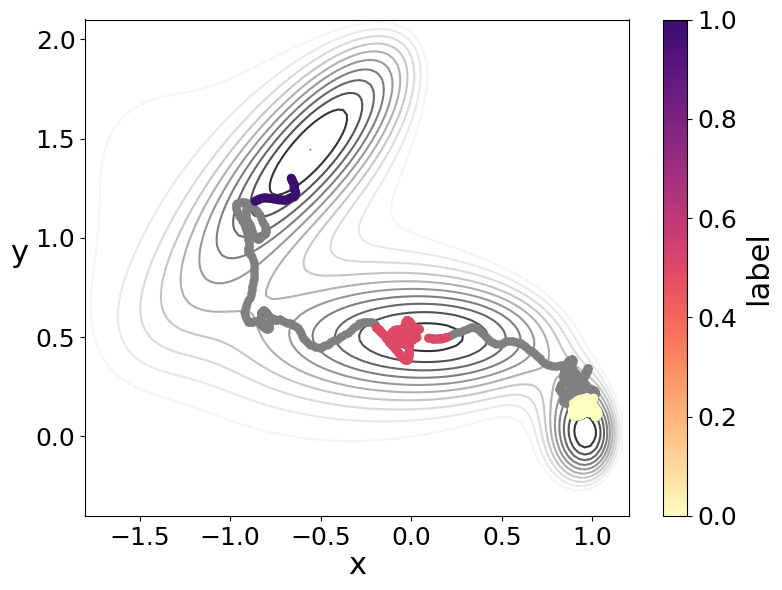

In [13]:
magma = plt.colormaps["magma_r"] 
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256)))  

fig, ax = plt.subplots(1, figsize=(8,6), dpi=100)               
ax.contour(xv,yv,pot,10,cmap='Greys_r')
ax.plot(training_datapoints[:,0],training_datapoints[:,1],'o', color='gray',markersize=5)
ndx=np.where((training_datapoints_labels!=2.0))[0]
pp=ax.scatter(training_datapoints[ndx,0],training_datapoints[ndx,1],c=training_datapoints_labels[ndx],s=30,cmap=new_magma,zorder=20)

cbar = plt.colorbar(pp, ax=ax)
cbar.set_label(r'label', rotation=90, labelpad=5,fontsize=22)
cbar.ax.tick_params(labelsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('x',fontsize=22,labelpad=1)
plt.ylabel('y', rotation=0,fontsize=22,labelpad=12)
plt.tight_layout()
plt.show()


In [14]:
dataset = TensorDataset(torch.Tensor(training_datapoints), torch.Tensor(training_datapoints_labels))

In [15]:
device = torch.device("cpu")

In [16]:
shuffle_dataset = True

dataset_size = len(dataset)
indices = list(range(dataset_size))
if shuffle_dataset:
    np.random.shuffle(indices)

# Split dataset into training and validation sets
train_size = int(0.8 * dataset_size)  # 80% for training, 20% for validation
val_size = dataset_size - train_size
train_indices, val_indices = indices[:train_size], indices[train_size:]
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Define batch size for training
batch_size_train = 64

# Create DataLoader for training set
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

val_features = []
val_labels = []
for val_index in val_indices:
    feature, label = dataset[val_index]
    val_features.append(feature)
    val_labels.append(label)

val_features = torch.stack(val_features)  
val_labels = torch.stack(val_labels)  

val_features = val_features.to(device)
val_labels = val_labels.to(device)
val_features.shape

torch.Size([221, 2])

In [17]:
for batch_idx, (features, labels) in enumerate(train_loader):
    if batch_idx == 0 :
        print(features.shape)
        print(labels.shape)
batch_size_train*batch_idx

torch.Size([64, 2])
torch.Size([64])


832

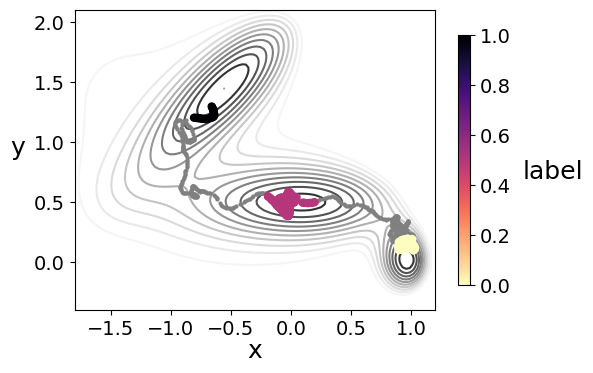

In [18]:
_, ax = plt.subplots(1, figsize=(6,5), dpi=100)
ax.contour(xv,yv,pot,10,cmap='Greys_r')

plt.plot(train_dataset[:][0][:,0],train_dataset[:][0][:,1],'o', color='gray',linewidth=1, markersize=2)
ndx=np.where((train_dataset[:][1]!=2.0))[0]
plt.scatter(train_dataset[:][0][ndx,0],train_dataset[:][0][ndx,1],c=train_dataset[:][1][ndx],s=25,cmap='magma_r',zorder=20)
cbar =plt.colorbar(shrink=0.6)
cbar.set_label(r'label', rotation=0, labelpad=30,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18,labelpad=0)
plt.ylabel('y', rotation=0,fontsize=18,labelpad=12)
plt.tight_layout()
ax.set_aspect('equal')
plt.show()

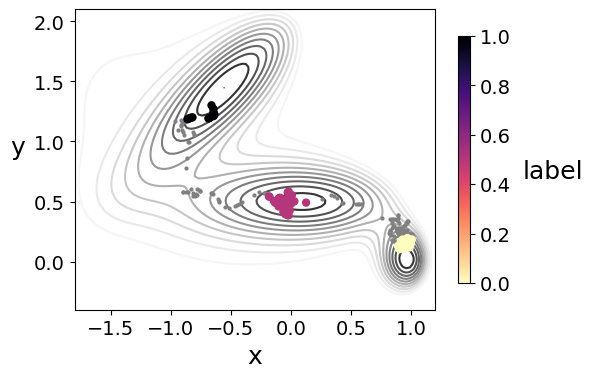

In [19]:
_, ax = plt.subplots(1, figsize=(6,5), dpi=100)
ax.contour(xv,yv,pot,10,cmap='Greys_r')

plt.plot(val_dataset[:][0][:,0],val_dataset[:][0][:,1],'o', color='gray',linewidth=1, markersize=2)
ndx=np.where((val_dataset[:][1]!=2.0))[0]
plt.scatter(val_dataset[:][0][ndx,0],val_dataset[:][0][ndx,1],c=val_dataset[:][1][ndx],s=25,cmap='magma_r',zorder=20)
cbar =plt.colorbar(shrink=0.6)
cbar.set_label(r'label', rotation=0, labelpad=30,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18)
plt.ylabel('y', rotation=0,fontsize=18,labelpad=12)
plt.tight_layout()
ax.set_aspect('equal')
plt.show()

In [20]:
class DeepLNE_CV(nn.Module):

    def __init__(self,
                ANN_layers: list,
                AutoEncoder_layers: list,
                f: int,
                d: int,
                n: int,
                ref: torch.Tensor,
                ref_z: torch.Tensor,
                act: str,
                z_lambda: float):
        

        super(DeepLNE_CV,self).__init__()
        
        # =======   LOSS  =======
        self.loss_mse = torch.nn.MSELoss()
        self.loss_ce = torch.nn.CrossEntropyLoss()
        

        # ======= BLOCKS =======
        
        self.n_features=f
        self.n_neighbors=n
        self.d_metric=d
        self.training_datapoints=ref
        self.training_datapoints_z=ref_z
        self.z_lambda=z_lambda
        
        print('Numer of input features:',self.n_features)
        print('Numer of neighbors:',self.n_neighbors)
        print('Dimension for nn search:',self.d_metric)
         
        if act == 'ReLU':
            self.activationf=torch.nn.ReLU()
        if act == 'Tanh':
            self.activationf=torch.nn.Tanh()
        if act == 'Sigmoid':
            self.activationf=torch.nn.Sigmoid()
        if act == 'ELU':
            self.activationf=torch.nn.ELU()
        if act == 'Softplus':    
            self.activationf=torch.nn.Softplus()
            
        self.ANNlayers = []
        
        self.ANNlayers.append(torch.nn.Linear(self.n_features, ANN_layers[0]))
        self.ANNlayers.append(self.activationf)
        
        for i in range(len(ANN_layers) - 1):
            self.ANNlayers.append(torch.nn.Linear(ANN_layers[i], ANN_layers[i + 1]))
            self.ANNlayers.append(self.activationf)

        self.ANNlayers.append(torch.nn.Linear(ANN_layers[-1], self.d_metric))
        
        self.metric = torch.nn.Sequential(*self.ANNlayers)
        print('ANN architecture: ',self.metric)
            

        # initialize encoder
        self.AutoEncoderLayers = []
        
        self.AutoEncoderLayers.append(torch.nn.Linear(int(self.n_neighbors*self.d_metric), AutoEncoder_layers[0]))
        self.AutoEncoderLayers.append(self.activationf)
        
        for i in range(len(AutoEncoder_layers) - 1):
            self.AutoEncoderLayers.append(torch.nn.Linear(AutoEncoder_layers[i], AutoEncoder_layers[i + 1]))
            self.AutoEncoderLayers.append(self.activationf)

        self.AutoEncoderLayers.append(torch.nn.Linear(AutoEncoder_layers[-1], 1))
        self.AutoEncoderLayers.append(torch.nn.Sigmoid())

        self.encoder = torch.nn.Sequential(*self.AutoEncoderLayers)
        print('Encoder architecture: ',self.encoder)
        
        # initialize decoder
        self.AutoDecoderLayers = []
        AutoDecoder_layers=AutoEncoder_layers[::-1]
        
        self.AutoDecoderLayers.append(torch.nn.Linear(1, AutoDecoder_layers[0]))
        self.AutoDecoderLayers.append(self.activationf)
        
        for i in range(len(AutoDecoder_layers) - 1):
            self.AutoDecoderLayers.append(torch.nn.Linear(AutoDecoder_layers[i], AutoDecoder_layers[i + 1]))
            self.AutoDecoderLayers.append(self.activationf)

        self.AutoDecoderLayers.append(torch.nn.Linear(AutoDecoder_layers[-1], self.n_features))

        self.decoder = torch.nn.Sequential(*self.AutoDecoderLayers)
        print('Decoder architecture: ',self.decoder)
    
    def softmax_w(self,x: torch.Tensor, t=1e-1) -> torch.Tensor:
        x = x / t
        x = x - torch.max(x, dim=1, keepdim=True)[0]
        return (torch.exp(x)+1e-6) / torch.sum(torch.exp(x), dim=1, keepdim=True)
        

    def soft_top_k(self,x: torch.Tensor,t: torch.Tensor) -> torch.Tensor:
        y = torch.zeros_like(x)
            
        for k in range(self.n_neighbors):
            y.fill_diagonal_(1)
            x_w = x * (1 - y)
            x_w_softmax = self.softmax_w(x_w)
            y = y+x_w_softmax
            
            dm=torch.matmul(t.T,x_w_softmax.T)
            
            if k == 0:
                dn=dm
            else:
                dn=torch.cat((dn,dm))
        return dn.T

    def learn_metric(self,x: torch.Tensor) -> torch.Tensor:
        d=self.metric(x)
        t=self.metric(self.training_datapoints)
        return d,t
    
    def find_nearest_neighbors(self,x: torch.Tensor,t: torch.Tensor) -> torch.Tensor:
        
        dist = torch.cdist(x, t)
        dist=torch.exp(-dist)
        dn = self.soft_top_k(dist,t)
        
        return dn
        
    def encode(self,x: torch.Tensor) -> torch.Tensor:
        x=self.encoder(x)
        return x
    
    def decode(self,x: torch.Tensor) -> torch.Tensor:
        x=self.decoder(x)
        return x
    
    def encode_decode(self, x: torch.Tensor) -> torch.Tensor:
        d,t=self.learn_metric(x)
        dn=self.find_nearest_neighbors(d,t)
        
        s=self.encode(dn)
        x_hat=self.decode(s) 
        
        return x_hat,s,d,dn
    
    def forward(self, x: torch.Tensor) -> torch.Tensor :
        d,t=self.learn_metric(x)
        dn=self.find_nearest_neighbors(d,t)
        s=self.encode(dn).reshape(-1,1)
        z=self.compute_z(x).reshape(-1,1)
        
        out=torch.hstack((s,z))
        
        return out
    
    def compute_z(self,x: torch.Tensor) -> torch.Tensor:
        z_dist=torch.cdist(x,self.training_datapoints_z)
        z_dist=torch.absolute(z_dist)
        z=(-1/self.z_lambda)*torch.log(torch.sum(torch.exp(-self.z_lambda*z_dist),axis=1))

        return z

In [21]:
training_datapoints=torch.Tensor(training_datapoints)
model_datapoints=torch.Tensor(model_datapoints)

ANN_architecture=[3]
AutoEncoder_architecture=[9,3]

n_features=2
d_metric=3
n_neighbors=3
l=10

model = DeepLNE_CV(ANN_layers=ANN_architecture,
                   AutoEncoder_layers=AutoEncoder_architecture,
                   f=n_features,
                   d=d_metric,
                   n=n_neighbors,
                   ref=model_datapoints,
                   ref_z=model_datapoints,
                   act='Tanh',
                   z_lambda=l)

device = torch.device("cpu")
optimizer = optim.Adam(model.parameters(), lr=0.001)

Numer of input features: 2
Numer of neighbors: 3
Dimension for nn search: 3
ANN architecture:  Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=3, bias=True)
)
Encoder architecture:  Sequential(
  (0): Linear(in_features=9, out_features=9, bias=True)
  (1): Tanh()
  (2): Linear(in_features=9, out_features=3, bias=True)
  (3): Tanh()
  (4): Linear(in_features=3, out_features=1, bias=True)
  (5): Sigmoid()
)
Decoder architecture:  Sequential(
  (0): Linear(in_features=1, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=9, bias=True)
  (3): Tanh()
  (4): Linear(in_features=9, out_features=2, bias=True)
)


In [35]:
alpha=1e-1
beta=1e-6

track_train = []
track_val = []
best_val_loss = float('inf')  

num_epochs = 5001
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):
        x = features.to(device)  
        l = labels.to(device) 
        
        x_hat,s,d,dn = model.encode_decode(x)

        reconstruction_loss = model.loss_mse(x_hat, x)
        
        ndx=torch.where(l!=2)[0]
        if len(ndx) > 0:
            multitask_loss = model.loss_mse(s.flatten()[ndx], l[ndx])
        else:
            multitask_loss = 0.0
        loss=reconstruction_loss+alpha*multitask_loss
        
        #L2 regularization
        for param in model.parameters():
            loss += beta * torch.norm(param, 2)

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

    train_loss = train_loss / batch_idx
    track_train.append(train_loss)
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        
        val_x = val_features.to(device)
        val_l = val_labels.to(device)

        x_hat,s,d,dn = model.encode_decode(val_x)

        reconstruction_loss = model.loss_mse(x_hat, val_x)
        
        ndx=torch.where(val_l!=2)[0]
        if len(ndx) > 0:
            multitask_loss = model.loss_mse(s.flatten()[ndx], val_l[ndx])
        else:
            multitask_loss = 0.0
        loss=reconstruction_loss+alpha*multitask_loss
        
    val_loss += loss.item() 

    track_val.append(val_loss)
    
    if epoch % 100 == 0:
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'model_teacher.pt')

    if train_loss < 1e-5:
        print(f"Converged at epoch {epoch}")
        break

Epoch: 0 	Training Loss: 36.389076 	Validation Loss: 0.513766
Epoch: 100 	Training Loss: 0.794257 	Validation Loss: 0.012459
Epoch: 200 	Training Loss: 0.699675 	Validation Loss: 0.011019
Epoch: 300 	Training Loss: 0.573102 	Validation Loss: 0.009150
Epoch: 400 	Training Loss: 0.261614 	Validation Loss: 0.004279
Epoch: 500 	Training Loss: 0.180903 	Validation Loss: 0.002819
Epoch: 600 	Training Loss: 0.152081 	Validation Loss: 0.002364
Epoch: 700 	Training Loss: 0.138462 	Validation Loss: 0.002213
Epoch: 800 	Training Loss: 0.130425 	Validation Loss: 0.002157
Epoch: 900 	Training Loss: 0.124261 	Validation Loss: 0.001994
Epoch: 1000 	Training Loss: 0.120699 	Validation Loss: 0.001954
Epoch: 1100 	Training Loss: 0.117183 	Validation Loss: 0.001913
Epoch: 1200 	Training Loss: 0.106111 	Validation Loss: 0.001732
Epoch: 1300 	Training Loss: 0.102542 	Validation Loss: 0.001565
Epoch: 1400 	Training Loss: 0.089599 	Validation Loss: 0.001424
Epoch: 1500 	Training Loss: 0.087904 	Validation Lo

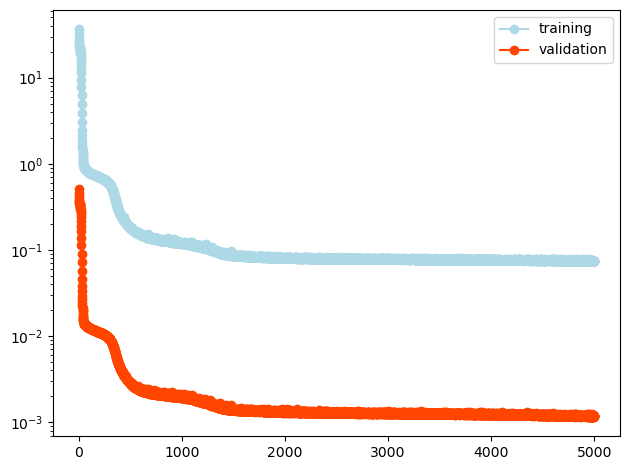

In [36]:
plt.figure()
plt.plot(track_train,'o-',color='lightblue',label='training')
plt.plot(track_val,'o-',color='orangered',label='validation')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
model.load_state_dict(torch.load('model_teacher.pt'), strict=False)
model_datapoints_z=model.encode_decode(model_datapoints)[0].detach().numpy()

training_datapoints=torch.Tensor(training_datapoints)
model_datapoints=torch.Tensor(model_datapoints)
model_datapoints_z=torch.Tensor(model_datapoints_z)

ANN_architecture=[3]
AutoEncoder_architecture=[9,3]

n_features=2
d_metric=3
n_neighbors=3
l=5e1

plumed_model = DeepLNE_CV(ANN_layers=ANN_architecture,
                   AutoEncoder_layers=AutoEncoder_architecture,
                   f=n_features,
                   d=d_metric,
                   n=n_neighbors,
                   ref=model_datapoints,
                   ref_z=model_datapoints_z,
                   act='Tanh',
                   z_lambda=l)

plumed_model.load_state_dict(torch.load('model_teacher.pt'), strict=False)

Numer of input features: 2
Numer of neighbors: 3
Dimension for nn search: 3
ANN architecture:  Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=3, bias=True)
)
Encoder architecture:  Sequential(
  (0): Linear(in_features=9, out_features=9, bias=True)
  (1): Tanh()
  (2): Linear(in_features=9, out_features=3, bias=True)
  (3): Tanh()
  (4): Linear(in_features=3, out_features=1, bias=True)
  (5): Sigmoid()
)
Decoder architecture:  Sequential(
  (0): Linear(in_features=1, out_features=3, bias=True)
  (1): Tanh()
  (2): Linear(in_features=3, out_features=9, bias=True)
  (3): Tanh()
  (4): Linear(in_features=9, out_features=2, bias=True)
)


<All keys matched successfully>

In [38]:
m=torch.jit.trace(plumed_model,torch.ones(1,n_features))
m.save('model_teacher.ptc')

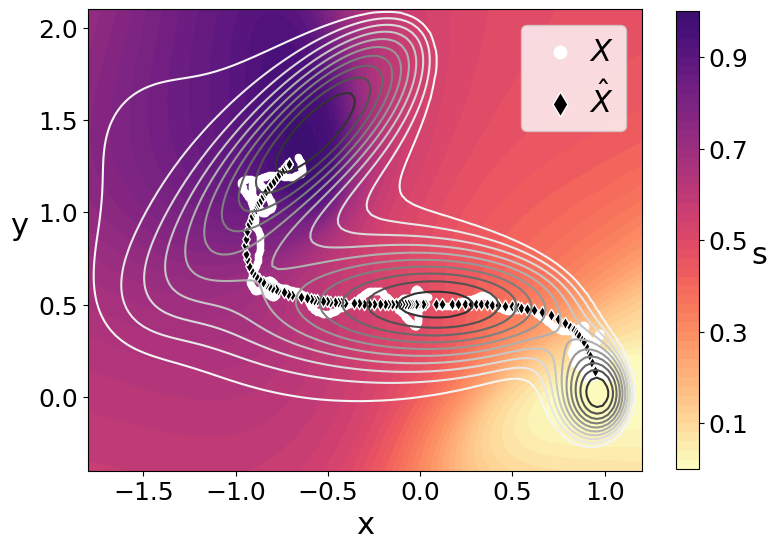

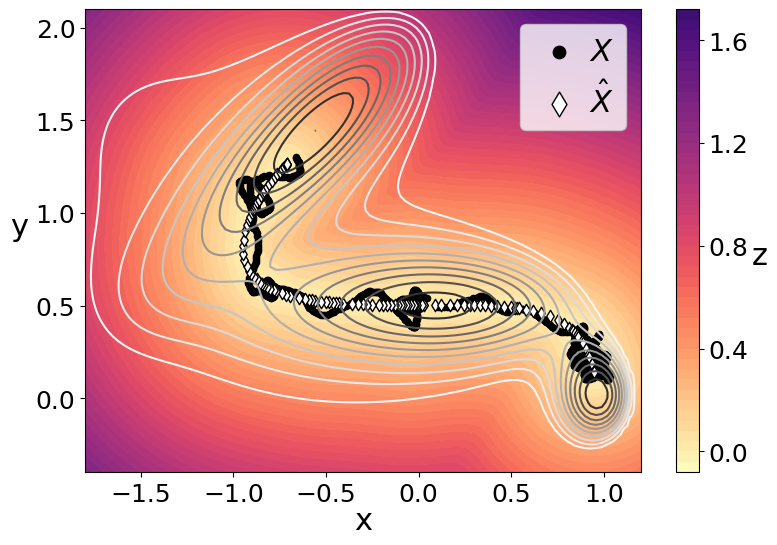

In [23]:
input=model_datapoints
x_hat,s,d,dn=plumed_model.encode_decode(input)
x_hat=x_hat.detach().numpy()

x_range = np.arange(-1.8, 1.2+0.01, 0.01)
y_range = np.arange(-0.4, 2.1+0.01, 0.01)

x_grid, y_grid = np.meshgrid(x_range, y_range)

grid_points = np.column_stack((x_grid.flatten(), y_grid.flatten()))

sample_grid=torch.Tensor(grid_points)

input=sample_grid
out=plumed_model(input)
s = out[:,0]
z = out[:,1]
s=s.detach().numpy()
z=z.detach().numpy()


grid_x = grid_points[:, 0].reshape(x_grid.shape)  
grid_y = grid_points[:, 1].reshape(x_grid.shape)  
grid_s = s.reshape(x_grid.shape)  
grid_z = z.reshape(x_grid.shape)  

magma = plt.colormaps["magma_r"] 
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256)))  


fig, ax = plt.subplots(1, figsize=(8,6), dpi=100)
contour2 = ax.contourf(grid_x,grid_y,grid_s,50,cmap=new_magma)
ax.contour(xv,yv,pot,10,cmap='Greys_r')
plt.scatter(training_datapoints.detach().numpy()[:,0], training_datapoints.detach().numpy()[:,1],color='white', s=20, marker='o',label=r'$X$')
plt.scatter(x_hat[:,0], x_hat[:,1],color='black', s=40, marker='d',edgecolors='white',label=r'$\hat{X}$')
cbar = plt.colorbar(contour2,ax=ax, shrink=0.87)
cbar.set_label(r's', rotation=0, labelpad=8,fontsize=22)
cbar.ax.tick_params(labelsize=18)
cbar.set_ticks(np.arange(0.1, 1, 0.2))
cbar.update_ticks()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('x',fontsize=22)
plt.ylabel('y', rotation=0,fontsize=22, labelpad=14)
ax.set_aspect('equal')
legend = plt.legend(loc='upper right', fontsize=22, markerscale=2, handlelength=1.75, handletextpad=0.1)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, figsize=(8,6), dpi=100)
contour2 = ax.contourf(grid_x,grid_y,grid_z,50,cmap=new_magma)
ax.contour(xv,yv,pot,10,cmap='Greys_r')

plt.scatter(training_datapoints.detach().numpy()[:,0], training_datapoints.detach().numpy()[:,1],color='black', s=20, marker='o',label=r'$X$')
plt.scatter(x_hat[:,0], x_hat[:,1],color='white', s=40, marker='d',edgecolors='black',label=r'$\hat{X}$')
cbar = plt.colorbar(contour2,ax=ax, shrink=0.87)
cbar.set_label(r'z', rotation=0, labelpad=8,fontsize=22)
cbar.ax.tick_params(labelsize=18)
cbar.locator = ticker.MultipleLocator(base=0.4)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('x',fontsize=22,labelpad=0)
plt.ylabel('y', rotation=0,fontsize=22,labelpad=12)
ax.set_aspect('equal')
legend = plt.legend(loc='upper right', fontsize=22, markerscale=2, handlelength=1.75, handletextpad=0.1)
plt.tight_layout()
plt.show()

In [43]:
#perform a short OPES using PYTORCH DeepLNE PATHCV

In [24]:
class ComputeSModel(torch.nn.Module):
    def __init__(self, milestones, l=4.0):
        super(ComputeSModel, self).__init__()
        self.milestones = torch.nn.Parameter(torch.tensor(milestones, dtype=torch.float32))
        self.l = torch.tensor(l, dtype=torch.float32)
    
    def forward(self, data_points):
        distances = torch.cdist(data_points, self.milestones.T)  
        exp_terms = torch.exp(-self.l * distances)  
        weights = torch.arange(1, distances.shape[1] + 1, device=distances.device, dtype=distances.dtype)
        numerator = torch.sum(exp_terms * weights, dim=1) 
        denominator = torch.sum(exp_terms, dim=1)  
        result = (numerator / denominator) 
        return result.unsqueeze(1) 

class ComputeZModel(torch.nn.Module):
    def __init__(self, milestones, z_lambda=1.0):
        super(ComputeZModel, self).__init__()
        self.milestones = torch.nn.Parameter(torch.tensor(milestones, dtype=torch.float32))
        self.z_lambda = torch.tensor(z_lambda, dtype=torch.float32)
    
    def forward(self, data_points):
        distances = torch.cdist(data_points, self.milestones.T) 
        exp_term = torch.exp(-self.z_lambda * distances) 
        z = (-1 / self.z_lambda) * torch.log(torch.sum(exp_term, dim=1))
        return z.unsqueeze(1) 


In [25]:
input=model_datapoints
x_hat,s,d,dn=plumed_model.encode_decode(input)

sorted_indices = torch.argsort(s.flatten())
x_hat = x_hat[sorted_indices,:] 

model = ComputeSModel(milestones=x_hat.T, l=10)

single_data_point = torch.ones(1,n_features)

traced_model = torch.jit.trace(model, single_data_point)

traced_model.save('s_analytic.ptc')

loaded_model = torch.jit.load('s_analytic.ptc')
output = loaded_model(single_data_point)
print("Output for single data point:", output)

model(torch.tensor([[0.0, 0.0]], dtype=torch.float32))
plumed_model(torch.tensor([[0.0, 0.0]], dtype=torch.float32))

test=torch.zeros((1,2),requires_grad=True)
test_s=model(test)
torch.autograd.grad(test_s,test)

input=model_datapoints
x_hat,s,d,dn=plumed_model.encode_decode(input)

sorted_indices = torch.argsort(s.flatten())
x_hat = x_hat[sorted_indices,:] 

model = ComputeZModel(milestones=x_hat.T, z_lambda=10.0)

single_data_point = torch.ones(1,n_features)

traced_model = torch.jit.trace(model, single_data_point)

traced_model.save('z_analytic.ptc')

loaded_model = torch.jit.load('z_analytic.ptc')
output = loaded_model(single_data_point)
print("Output for single data point:", output)

model(torch.tensor([[0.0, 0.0]], dtype=torch.float32))
plumed_model(torch.tensor([[0.0, 0.0]], dtype=torch.float32))

test=torch.zeros((1,2),requires_grad=True)
test_z=model(test)
torch.autograd.grad(test_z,test)

x_hat=x_hat.detach().numpy()

Output for single data point: tensor([[52.0352]], grad_fn=<UnsqueezeBackward0>)
Output for single data point: tensor([[0.2980]], grad_fn=<UnsqueezeBackward0>)


/tmp/ipykernel_217810/1931904312.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.milestones = torch.nn.Parameter(torch.tensor(milestones, dtype=torch.float32))
/tmp/ipykernel_217810/1931904312.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.milestones = torch.nn.Parameter(torch.tensor(milestones, dtype=torch.float32))


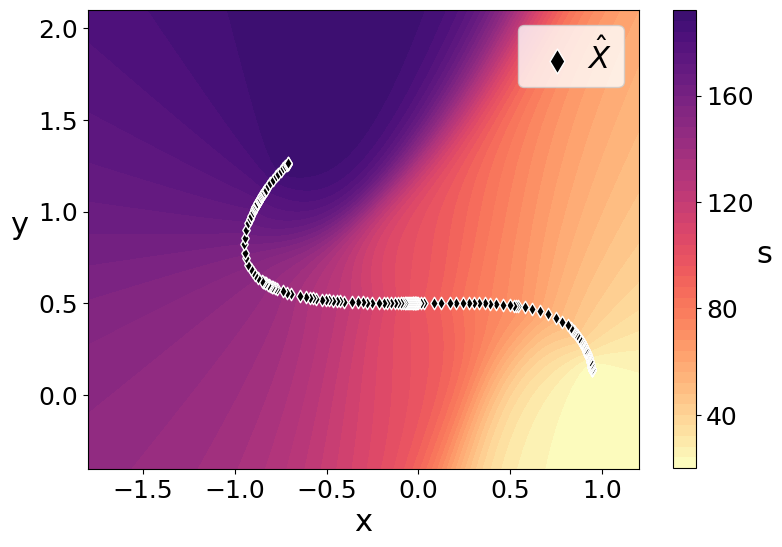

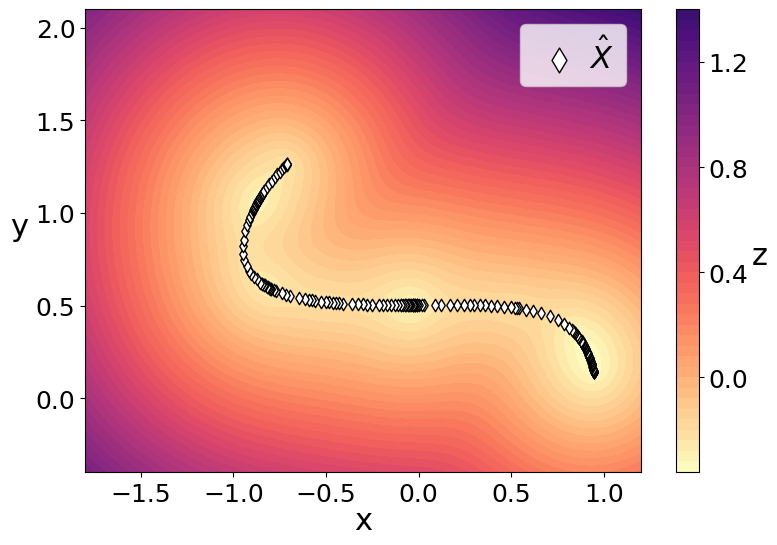

In [26]:
# Load the models
model_s = torch.jit.load('s_analytic.ptc')

# Prepare grid for plotting
x_range = np.arange(-1.8, 1.2 + 0.01, 0.01)
y_range = np.arange(-0.4, 2.1 + 0.01, 0.01)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.column_stack((x_grid.flatten(), y_grid.flatten()))
sample_grid = torch.tensor(grid_points, dtype=torch.float32)

# Compute s and z values using the models
with torch.no_grad():
    s_values_tensor = model_s(sample_grid)

s_values = s_values_tensor.numpy()

# Reshape for plotting
grid_x = grid_points[:, 0].reshape(x_grid.shape)
grid_y = grid_points[:, 1].reshape(x_grid.shape)
grid_s = s_values.reshape(x_grid.shape)

# Define colormap
magma = plt.colormaps["magma_r"]
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256)))

# Plotting s values
fig, ax = plt.subplots(1, figsize=(8, 6), dpi=100)
contour_s = ax.contourf(grid_x, grid_y, grid_s, 50, cmap=new_magma)
plt.scatter(x_hat[:, 0], x_hat[:, 1], color='black', s=40, marker='d', edgecolors='white', label=r'$\hat{X}$')

# Create colorbar and fix issues
cbar_s = plt.colorbar(contour_s, ax=ax, shrink=0.87)
cbar_s.set_label(r's', rotation=0, labelpad=8, fontsize=22)
cbar_s.ax.tick_params(labelsize=18)

# Automatically adjust tick locations based on data range
cbar_s.locator = ticker.MaxNLocator(nbins=5)  # Adjust the number of ticks to display
cbar_s.update_ticks()

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('x', fontsize=22)
plt.ylabel('y', rotation=0, fontsize=22, labelpad=14)
ax.set_aspect('equal')
plt.legend(loc='upper right', fontsize=22, markerscale=2, handlelength=1.75, handletextpad=0.1)
plt.tight_layout()
plt.show()

model_z = torch.jit.load('z_analytic.ptc')

# Prepare grid for plotting
x_range = np.arange(-1.8, 1.2 + 0.01, 0.01)
y_range = np.arange(-0.4, 2.1 + 0.01, 0.01)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.column_stack((x_grid.flatten(), y_grid.flatten()))
sample_grid = torch.tensor(grid_points, dtype=torch.float32)

# Compute s and z values using the models
with torch.no_grad():
    z_values_tensor = model_z(sample_grid)

z_values = z_values_tensor.numpy()

# Reshape for plotting
grid_x = grid_points[:, 0].reshape(x_grid.shape)
grid_y = grid_points[:, 1].reshape(x_grid.shape)
grid_z = z_values.reshape(x_grid.shape)

# Define colormap
magma = plt.colormaps["magma_r"]
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256)))


# Plotting z values
fig, ax = plt.subplots(1, figsize=(8, 6), dpi=100)
contour_z = ax.contourf(grid_x, grid_y, grid_z, 50, cmap=new_magma)
plt.scatter(x_hat[:, 0], x_hat[:, 1], color='white', s=40, marker='d', edgecolors='black', label=r'$\hat{X}$')
cbar_z = plt.colorbar(contour_z, ax=ax, shrink=0.87)
cbar_z.set_label(r'z', rotation=0, labelpad=8, fontsize=22)
cbar_z.ax.tick_params(labelsize=18)
cbar_z.locator = ticker.MultipleLocator(base=0.4)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('x', fontsize=22, labelpad=0)
plt.ylabel('y', rotation=0, fontsize=22, labelpad=12)
ax.set_aspect('equal')
plt.legend(loc='upper right', fontsize=22, markerscale=2, handlelength=1.75, handletextpad=0.1)
plt.tight_layout()
plt.show()


In [31]:
folder = 'OPES_analytical/'

Path(folder).mkdir(parents=True, exist_ok=True)

# md_potential for ves_md_linearexpansion (actual potential is in plumed.dat)
with open(folder+"md_potential","w") as f:
    print("""#! FIELDS idx_dim1 idx_dim2 pot.coeffs index description
#! SET type LinearBasisSet
#! SET ndimensions  2
#! SET ncoeffs_total 9 
#! SET shape_dim1  3
#! SET shape_dim2  3
       0       0         0.0000000000000000e+00       0  1*1
#!-------------------
""",file=f)

# md_input for ves_md_linearexpansion
with open(folder+"md_input","w") as f:
    print("""
nstep                   1000000
tstep                   0.005
temperature             1.0
friction                10.0
random_seed             1  
plumed_input            plumed.dat
dimension               2
replicas                1
basis_functions_1       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
basis_functions_2       BF_POWERS ORDER=2 MINIMUM=-4.0 MAXIMUM=+4.0
input_coeffs            md_potential
initial_position        0,0.5
output_potential        out_potential.data
output_potential_grid   100
output_histogram        histogram.data
""",file=f)

with open(folder+"plumed.dat","w") as f:
    print(f"""# vim:ft=plumed 
UNITS NATURAL
p: POSITION ATOM=1
ene: CUSTOM ARG=p.x,p.y PERIODIC=NO FUNC={MULLER_BROWN_FORMULA}
pot: BIASVALUE ARG=ene

model_s: PYTORCH_MODEL FILE=s_analytic.ptc ARG=p.x,p.y
model_z: PYTORCH_MODEL FILE=z_analytic.ptc ARG=p.x,p.y

opes: OPES_METAD ARG=model_s.node-0 BARRIER=15 PACE=200

lwall: LOWER_WALLS ARG=p.x KAPPA=1000 AT=-1.3
uwall: UPPER_WALLS ARG=p.x KAPPA=1000 AT=+1.5
uwall2: UPPER_WALLS ARG=model_z.node-0 KAPPA=2000 AT=0.1

DEBUG DETAILED_TIMERS

PRINT STRIDE=200 ARG=* FILE=COLVAR_analytical_DeepLNE
""",file=f)

In [28]:
!scp s_analytic.ptc OPES_analytical/
!scp z_analytic.ptc OPES_analytical/

In [ ]:
#execute in shell
plumed ves_md_linearexpansion < md_input

5001


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


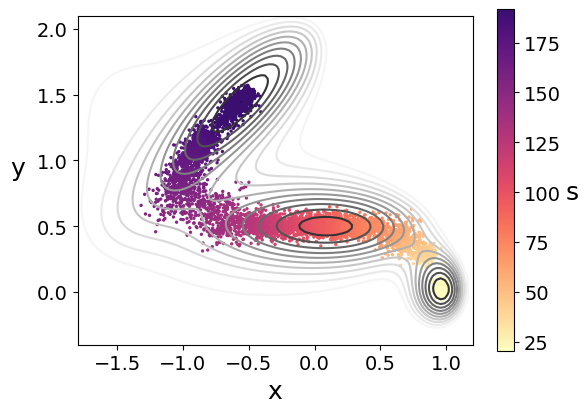

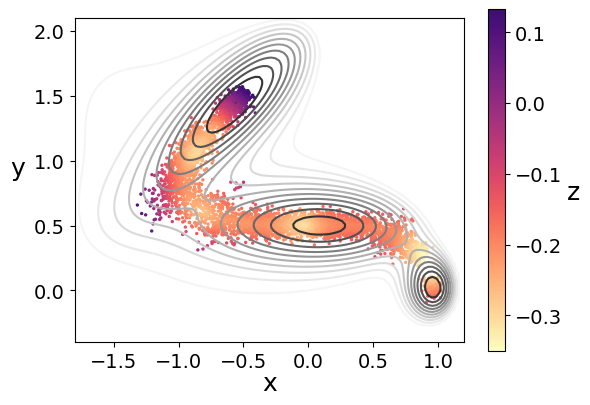

In [41]:
folder = 'OPES_analytical/'
colvar = plumed.read_as_pandas(folder+"COLVAR_analytical_DeepLNE")
print(len(colvar))

magma = plt.colormaps["magma_r"] 
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256)))  

fig, ax = plt.subplots(1, figsize=(6,6), dpi=100)
ax.contour(xv,yv,pot,10,cmap='Greys_r')
s =plt.scatter(colvar['p.x'],colvar['p.y'],c=colvar['model_s.node-0'],cmap=new_magma,s=2)
cbar = plt.colorbar(s,ax=ax, shrink=0.6)
cbar.set_label(r's', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18)
plt.ylabel('y', rotation=0,fontsize=18, labelpad=14)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, figsize=(6,6), dpi=100)
ax.contour(xv,yv,pot,10,cmap='Greys_r')
s =plt.scatter(colvar['p.x'],colvar['p.y'],c=colvar['model_z.node-0'],cmap=new_magma,s=2)
cbar = plt.colorbar(s,ax=ax, shrink=0.6)
cbar.set_label(r'z', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x',fontsize=18,labelpad=0)
plt.ylabel('y', rotation=0,fontsize=18,labelpad=12)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()